# Problem Statement : Customer Segmetation

Online reatil is a transnational data set which contains all the transction occuring between 01/12/2010 and 09/12/2011 for a UK-based and registred non-store online retail. The company mainly sells unique all-occasion gifts.Many customeers of the company are wholesalers.

## What we want to achive ?

Segement the customers based on RFM so that the company can target its customers efficiently.

#### R (Recency) : Number of days since last purchase
#### F (Frequency) : Number of transctions
#### M (Monetary) : Total amount of transctions (revenue contributed)

In [1]:
# Import required libraries for clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
retail = pd.read_csv("OnlineRetail.csv", sep=",", encoding="ISO_8859-1",header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail.shape  ## Shape of dataframe

(541909, 8)

In [4]:
# Dataframe info
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Data Cleaning

In [5]:
# Calculating the missing values % contribution in dataframe

df_null = round(100* (retail.isnull().sum())/len(retail),2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [6]:
# dropping rows having missing values
retail =  retail.dropna()
retail.shape

(406829, 8)

In [7]:
# Changing the datatypes of CustomerID and InvoiceDate

retail.CustomerID = retail.CustomerID.astype('str')
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [8]:
# New attribute : Monetary

retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
rfm_m = retail.groupby("CustomerID")['Amount'].sum().reset_index()

rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [9]:
# New attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count().reset_index()
rfm_f.columns = ['CustomerID','Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [10]:
## Merging two dataframes

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [11]:
# New attribute : Recency

# Compute the maximum date to know the last transction date
max_date = retail['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:50:00')

In [12]:
# Compute The difference between max date and transction date
retail['Diff'] = max_date - retail.InvoiceDate
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [13]:
rfm_p =  retail.groupby('CustomerID')['Diff'].min().reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [14]:
# Extract  days only from diff

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [15]:
# merge datraframes

rfm = pd.merge(rfm , rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID','Amount','Frequency','Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### Outlier Analysis of Amount,Frequency and Recency

Text(0, 0.5, 'Range')

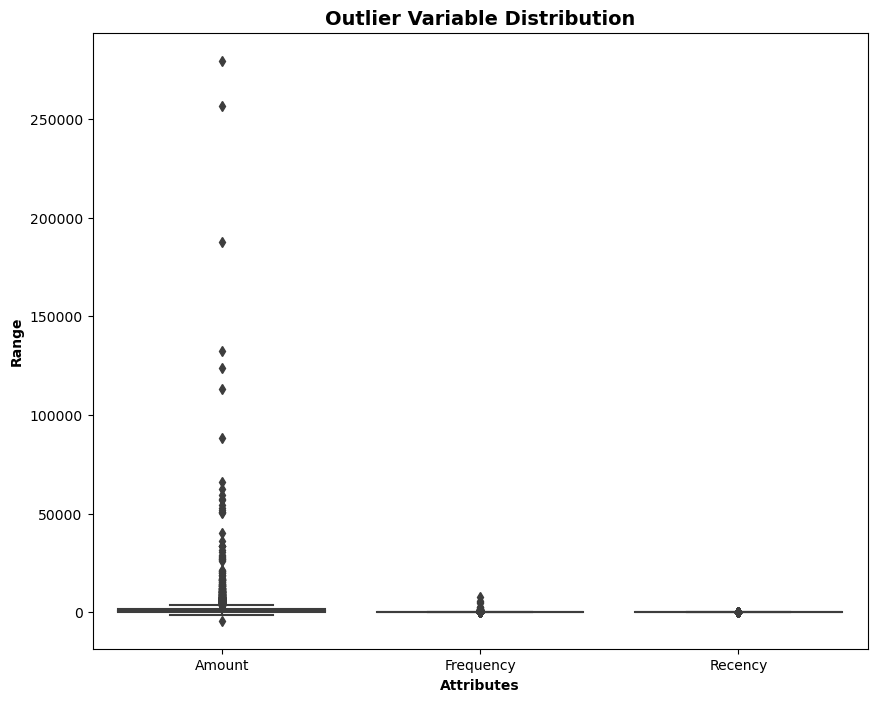

In [16]:
attributes = ['Amount','Frequency','Recency']
plt.figure(figsize=(10,8))
sns.boxplot(data = rfm[attributes])
plt.title("Outlier Variable Distribution",fontsize=14, fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')
plt.ylabel("Range", fontweight='bold')

In [17]:
# Removing (statistical) outliers for Amount
q1 = rfm.Amount.quantile(0.05)
q3 = rfm.Amount.quantile(0.95)
iqr = q3 - q1
rfm = rfm[(rfm.Amount >= q1-1.5*iqr) & (rfm.Amount <= q3+1.5*iqr)]

# Removing (statistical) outliers for Recency
q1 = rfm.Recency.quantile(0.05)
q3 = rfm.Recency.quantile(0.95)
iqr = q3 - q1
rfm = rfm[(rfm.Recency >= q1-1.5*iqr) & (rfm.Recency <= q3+1.5*iqr)]

# Removing (statistical) outliers for Frequency
q1 = rfm.Frequency.quantile(0.05)
q3 = rfm.Frequency.quantile(0.95)
iqr = q3 - q1
rfm = rfm[(rfm.Frequency >= q1-1.5*iqr) & (rfm.Frequency <= q3+1.5*iqr)]

## Scaling

In [18]:
rfm_df = rfm[['Amount','Frequency','Recency']]
scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [19]:
rfm_df_scaled  = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount','Frequency','Recency']

# Model Building

In [20]:
# K-means with some arbitary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [21]:
kmeans.labels_

array([0, 3, 1, ..., 0, 1, 1])

In [22]:
set(kmeans.labels_)

{0, 1, 2, 3}

## Elboe curve to get optimal k value

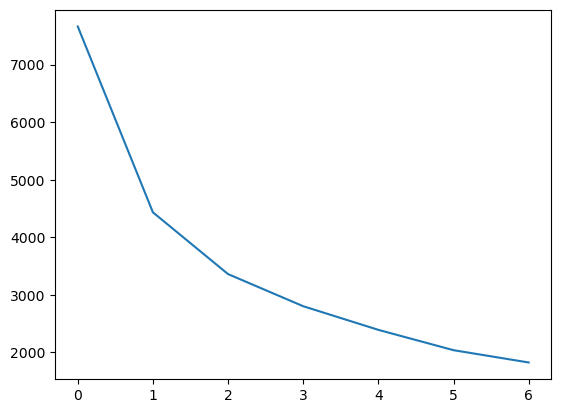

In [23]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)

# plot the ssd for each clusters
plt.plot(ssd)

In [24]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=300)
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=3)

In [25]:
print(kmeans.labels_)
print(set(kmeans.labels_))

[0 1 2 ... 0 2 2]
{0, 1, 2}


In [26]:
kmeans.predict(rfm_df_scaled)

array([0, 1, 2, ..., 0, 2, 2])

In [27]:
## assign the label
rfm['cluster_Id'] = kmeans.predict(rfm_df_scaled)
rfm

,CustomerID,Amount,Frequency,Recency,cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0
...,...,...,...,...,...
4366,18278.0,173.90,9,73,2
4367,18280.0,180.60,10,277,0
4368,18281.0,80.82,7,180,0
4369,18282.0,176.60,13,7,2


<Axes: xlabel='cluster_Id', ylabel='Amount'>

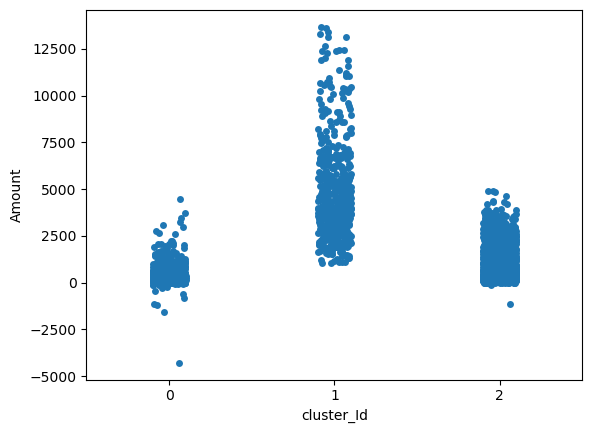

In [28]:
# Boxplot to visualize cluster id vs amount
sns.stripplot(x='cluster_Id',y='Amount', data=rfm)

<Axes: xlabel='cluster_Id', ylabel='Frequency'>

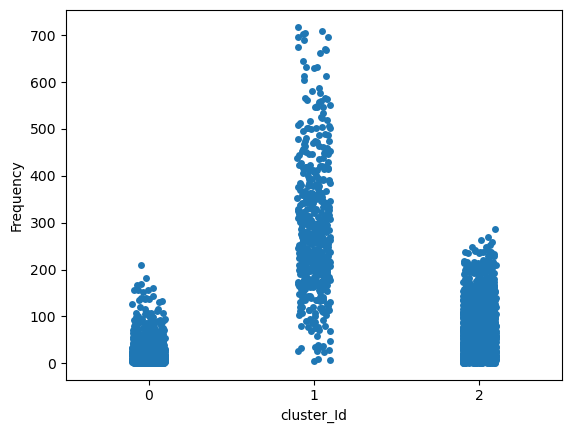

In [29]:
# Boxplot to visualize cluster id vs Frequency
sns.stripplot(x='cluster_Id',y='Frequency', data=rfm)

<Axes: xlabel='cluster_Id', ylabel='Recency'>

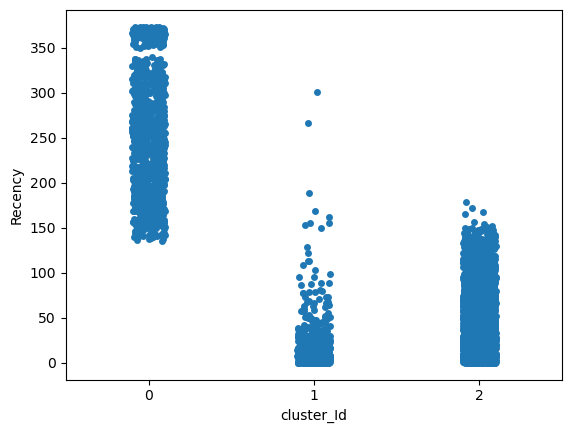

In [30]:
# Boxplot to visualize cluster id vs Recency
sns.stripplot(x='cluster_Id',y='Recency', data=rfm)

In [31]:
## Define file name for pickle file
import pickle
filename = 'kmeans_model.pkl'

## Open file in write model
with open ('kmeans_saved_model','wb') as file:
    #save the kmeans model to the file
    pickle.dump(kmeans, file)
    
# close the file
file.close()

pickle.dump(kmeans, open('kmeans_model.pkl','wb'))